# In-depth analysis Part 2

# Consumer Segmentation San Francisco and Miami

In this section we focus on the data from the Household Pulse Survey to find relationships between shopping variables and demographics, as well as applying Machine Learning techniques to generate customer segmentations.

In [1]:
import pandas as pd
import numpy as np
import indepth_functions
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('../data/interim/census/household_shopping_concat.csv')

In [3]:
df['GENERATION'] = df.TBIRTH_YEAR.apply(indepth_functions.generation_)

## San Francisco

In [4]:
EST_MSA = 41860
name_location = 'San Francisco Bay Area'

In [5]:
df_sf = df[df.EST_MSA == EST_MSA]

In [6]:
demographics = ['EGENDER', 'RHISPANIC', 
                    'RRACE',
                    'EEDUC', 'MS', 
                    'THHLD_NUMKID', 'THHLD_NUMADLT', 'INCOME', 'EXPNS_DIF']

In [7]:
shopping_vars = ['ONLINE','PICK-UP','IN-STORE','RFID-NFC', 'CASH', 'AVOID RESTR','RESUME RESTR']

In [8]:
df_sf.rename({'CHNGHOW1': 'ONLINE',
           'CHNGHOW2': 'PICK-UP',
           'CHNGHOW3': 'IN-STORE',
           'CHNGHOW4': 'RFID-NFC', 
           'CHNGHOW5': 'CASH', 
           'CHNGHOW6': 'AVOID RESTR',
           'CHNGHOW7': 'RESUME RESTR'}, axis=1, inplace=True)

In [9]:
df_sf = df_sf.replace({np.nan: 0})

In [10]:
df_sf = df_sf.loc[:, demographics+shopping_vars]

In [11]:
df_sf.head()

,EGENDER,RHISPANIC,RRACE,EEDUC,MS,THHLD_NUMKID,THHLD_NUMADLT,INCOME,EXPNS_DIF,ONLINE,PICK-UP,IN-STORE,RFID-NFC,CASH,AVOID RESTR,RESUME RESTR
911,2.0,1.0,3.0,6.0,5.0,0.0,2.0,8.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
912,2.0,1.0,2.0,3.0,2.0,2.0,1.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
913,1.0,1.0,1.0,7.0,1.0,0.0,2.0,7.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
914,2.0,1.0,1.0,7.0,5.0,0.0,2.0,8.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
917,1.0,1.0,1.0,6.0,1.0,0.0,2.0,8.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


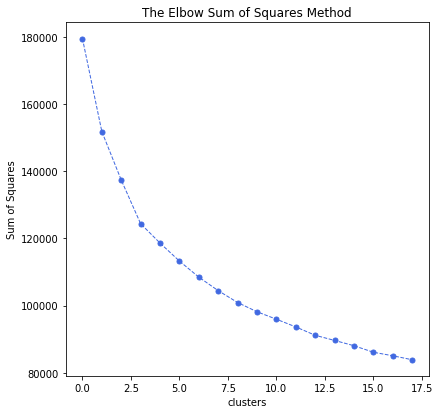

In [12]:
x_cols = df_sf
K = np.arange(2, 20, 1)
inertias = []

for k in K:
    model = KMeans(n_clusters=k)
    model.fit(x_cols)
    inertias.append(model.inertia_)
    
f, ax = plt.subplots(figsize=(6.5, 6.5))  
_ = plt.plot(inertias, linewidth=1, markersize=5, marker='o', linestyle='dashed', color='royalblue') 
_ = plt.xlabel('clusters')
_ = plt.ylabel('Sum of Squares')
_ = plt.title('The Elbow Sum of Squares Method')
plt.show()

Lower values of SS represent lower distances between points and the centroid of the cluster where they were assigned. We want to know how much clusters are necessary to separate classes the maximum possible between them but asserting that the points into them are close to the centroid. Otherwise, why do those points belong to a cluster and don't belong to another?

The challenge of using this method is how to determine the elbow point. We are looking for a point where SS starts to decrease more slowly and in this case, this point could be 1, or 5, for example. If the 'elbow' is not extremely clear and easy to find, Elbow method just gives you a notion of the range that you must inspect.

Let's use 4 clusters:

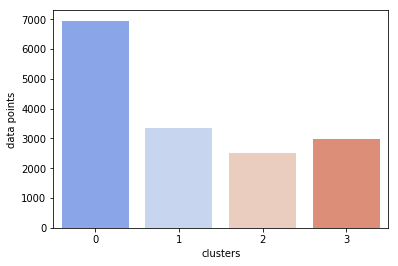

In [13]:
k = 4
model = KMeans(n_clusters=k, random_state=0)
labels_true = model.fit_predict(x_cols)
df_sf['CLUSTER'] = labels_true

df_clusters = df_sf.groupby('CLUSTER').count().head()
_ = sns.countplot(x=df_sf['CLUSTER'], data=df_sf, palette='coolwarm')
_ = plt.xlabel('clusters')
_ = plt.ylabel('data points')

In [14]:
df_sf['CLUSTER'].value_counts(normalize=True)

0    0.440583
1    0.211351
3    0.187888
2    0.160178
Name: CLUSTER, dtype: float64

The Figure below shows the number of datapoints into each cluster. Cluster 0 encompasses almost 65% of the population. Let's explore the composition of every cluster:

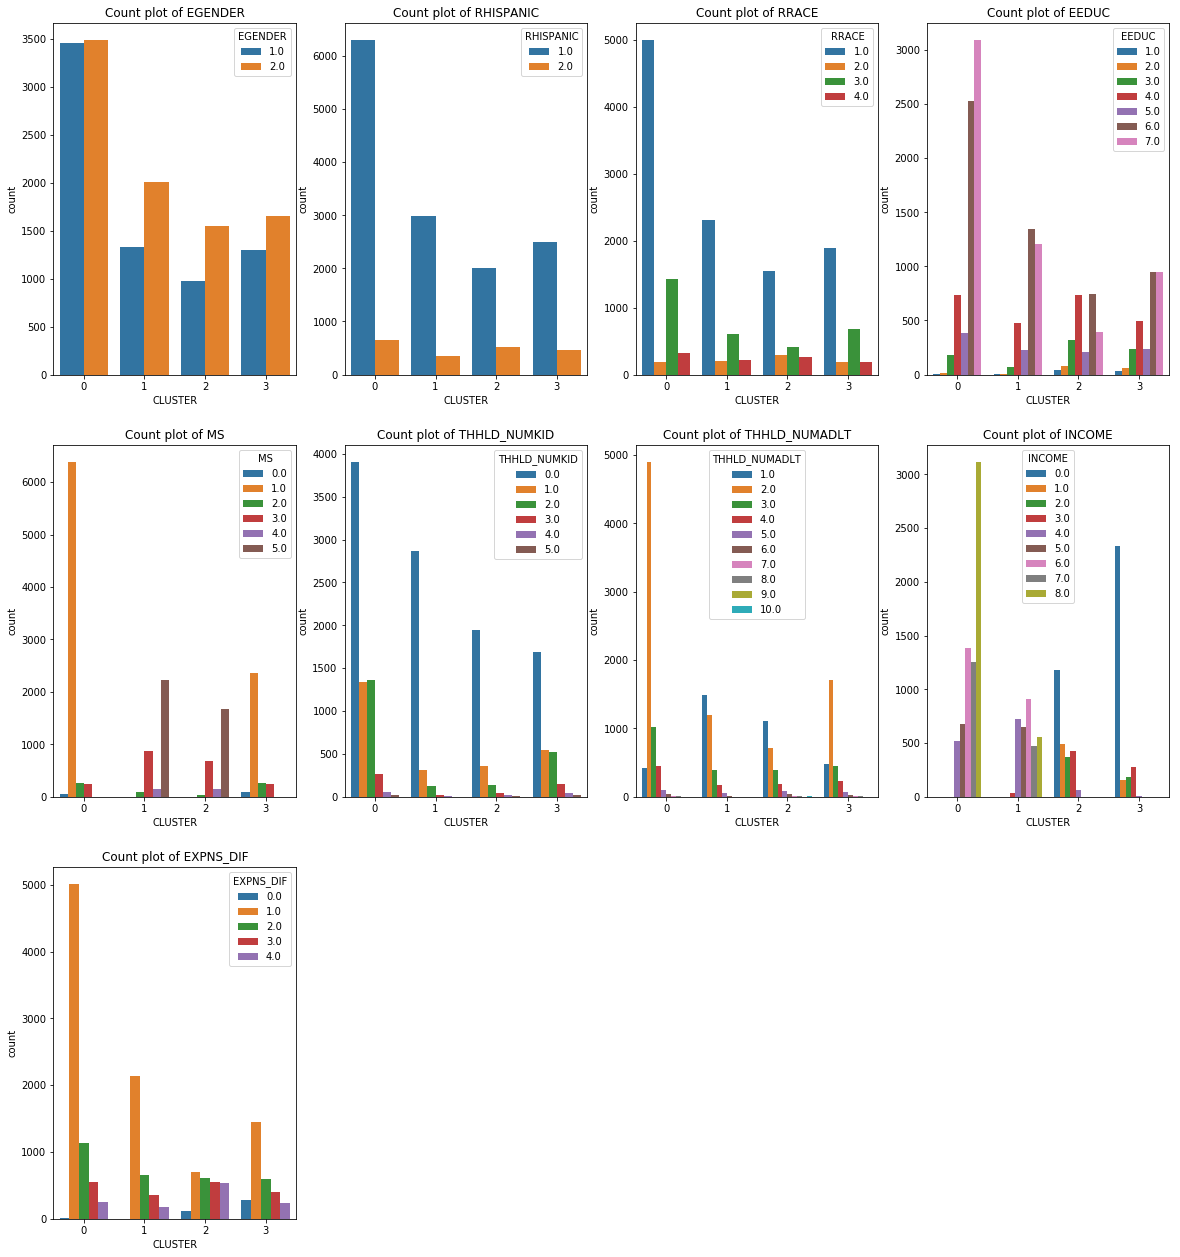

In [15]:
plt.figure(figsize=(20,22))
vars_to_look = demographics
for i, var in enumerate(vars_to_look):
    plt.subplot(3,4,i+1)
    if i ==10:
        plt.xticks(rotation = 90)
    sns.countplot(x='CLUSTER', hue=var, data=df_sf)
    plt.title("Count plot of " + var)    

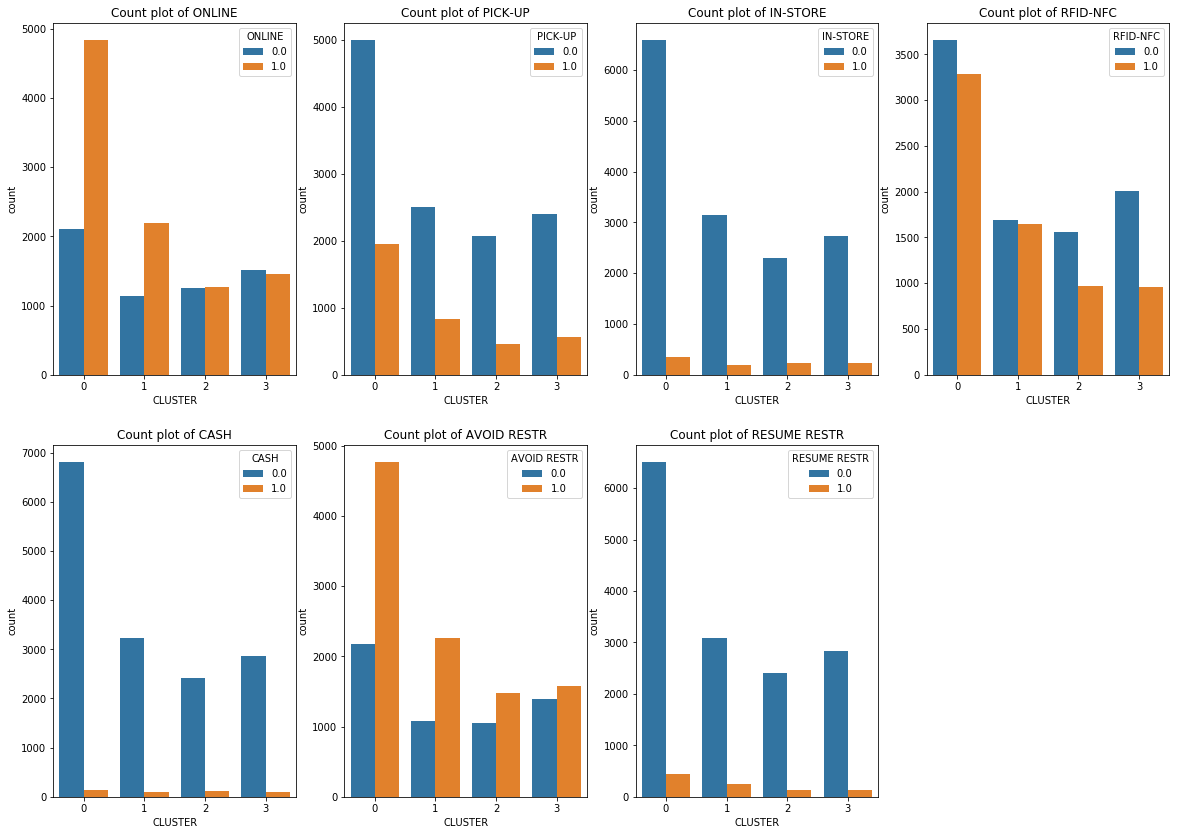

In [16]:
plt.figure(figsize=(20,22))
vars_to_look = shopping_vars
for i, var in enumerate(vars_to_look):
    plt.subplot(3,4,i+1)
    if i ==10:
        plt.xticks(rotation = 90)
    sns.countplot(hue=var, x='CLUSTER', data=df_sf)
    plt.title("Count plot of " + var)    

In [17]:
temp_income = df_sf.groupby(['CLUSTER', 'AVOID RESTR']).count()
temp_income = (temp_income/temp_income.groupby(level=[0]).sum())*100
temp_income

EGENDER  RHISPANIC      RRACE      EEDUC         MS  \
CLUSTER AVOID RESTR                                                          
0       0.0          31.332758  31.332758  31.332758  31.332758  31.332758   
        1.0          68.667242  68.667242  68.667242  68.667242  68.667242   
1       0.0          32.223222  32.223222  32.223222  32.223222  32.223222   
        1.0          67.776778  67.776778  67.776778  67.776778  67.776778   
2       0.0          41.567696  41.567696  41.567696  41.567696  41.567696   
        1.0          58.432304  58.432304  58.432304  58.432304  58.432304   
3       0.0          46.878164  46.878164  46.878164  46.878164  46.878164   
        1.0          53.121836  53.121836  53.121836  53.121836  53.121836   

                     THHLD_NUMKID  THHLD_NUMADLT     INCOME  EXPNS_DIF  \
CLUSTER AVOID RESTR                                                      
0       0.0             31.332758      31.332758  31.332758  31.332758   
        1.0             68.667242      68.667242  68.667242  68.667242   
1       0.0             32.223222      32.223222  32.223222  32.223222   
        1.0             67.776778      67.776778  67.776778  67.776778   
2       0.0             41.567696      41.567696  41.567696  41.567696   
        1.0             58.432304      58.432304  58.432304  58.432304   
3       0.0             46.878164      46.878164  46.878164  46.878164   
        1.0             53.121836      53.121836  53.121836  53.121836   

                        ONLINE    PICK-UP   IN-STORE   RFID-NFC       CASH  \
CLUSTER AVOID RESTR                                                          
0       0.0          31.332758  31.332758  31.332758  31.332758  31.332758   
        1.0          68.667242  68.667242  68.667242  68.667242  68.667242   
1       0.0          32.223222  32.223222  32.223222  32.223222  32.223222   
        1.0          67.776778  67.776778  67.776778  67.776778  67.776778   
2       0.0          41.567696  41.567696  41.567696  41.567696  41.567696   
        1.0          58.432304  58.432304  58.432304  58.432304  58.432304   
3       0.0          46.878164  46.878164  46.878164  46.878164  46.878164   
        1.0          53.121836  53.121836  53.121836  53.121836  53.121836   

                     RESUME RESTR  
CLUSTER AVOID RESTR                
0       0.0             31.332758  
        1.0             68.667242  
1       0.0             32.223222  
        1.0             67.776778  
2       0.0             41.567696  
        1.0             58.432304  
3       0.0             46.878164  
        1.0             53.121836

In [18]:
temp_income = df_sf.groupby(['CLUSTER', 'ONLINE']).count()
temp_income = (temp_income/temp_income.groupby(level=[0]).sum())*100
temp_income

EGENDER  RHISPANIC      RRACE      EEDUC         MS  \
CLUSTER ONLINE                                                          
0       0.0     30.296488  30.296488  30.296488  30.296488  30.296488   
        1.0     69.703512  69.703512  69.703512  69.703512  69.703512   
1       0.0     34.053405  34.053405  34.053405  34.053405  34.053405   
        1.0     65.946595  65.946595  65.946595  65.946595  65.946595   
2       0.0     49.762470  49.762470  49.762470  49.762470  49.762470   
        1.0     50.237530  50.237530  50.237530  50.237530  50.237530   
3       0.0     50.928113  50.928113  50.928113  50.928113  50.928113   
        1.0     49.071887  49.071887  49.071887  49.071887  49.071887   

                THHLD_NUMKID  THHLD_NUMADLT     INCOME  EXPNS_DIF    PICK-UP  \
CLUSTER ONLINE                                                                 
0       0.0        30.296488      30.296488  30.296488  30.296488  30.296488   
        1.0        69.703512      69.703512  69.703512  69.703512  69.703512   
1       0.0        34.053405      34.053405  34.053405  34.053405  34.053405   
        1.0        65.946595      65.946595  65.946595  65.946595  65.946595   
2       0.0        49.762470      49.762470  49.762470  49.762470  49.762470   
        1.0        50.237530      50.237530  50.237530  50.237530  50.237530   
3       0.0        50.928113      50.928113  50.928113  50.928113  50.928113   
        1.0        49.071887      49.071887  49.071887  49.071887  49.071887   

                 IN-STORE   RFID-NFC       CASH  AVOID RESTR  RESUME RESTR  
CLUSTER ONLINE                                                              
0       0.0     30.296488  30.296488  30.296488    30.296488     30.296488  
        1.0     69.703512  69.703512  69.703512    69.703512     69.703512  
1       0.0     34.053405  34.053405  34.053405    34.053405     34.053405  
        1.0     65.946595  65.946595  65.946595    65.946595     65.946595  
2       0.0     49.762470  49.762470  49.762470    49.762470     49.762470  
        1.0     50.237530  50.237530  50.237530    50.237530     50.237530  
3       0.0     50.928113  50.928113  50.928113    50.928113     50.928113  
        1.0     49.071887  49.071887  49.071887    49.071887     49.071887

In [19]:
temp_income = df_sf.groupby(['CLUSTER', 'PICK-UP']).count()
temp_income = (temp_income/temp_income.groupby(level=[0]).sum())*100
temp_income

EGENDER  RHISPANIC      RRACE      EEDUC         MS  \
CLUSTER PICK-UP                                                          
0       0.0      71.919977  71.919977  71.919977  71.919977  71.919977   
        1.0      28.080023  28.080023  28.080023  28.080023  28.080023   
1       0.0      74.857486  74.857486  74.857486  74.857486  74.857486   
        1.0      25.142514  25.142514  25.142514  25.142514  25.142514   
2       0.0      81.868567  81.868567  81.868567  81.868567  81.868567   
        1.0      18.131433  18.131433  18.131433  18.131433  18.131433   
3       0.0      81.100236  81.100236  81.100236  81.100236  81.100236   
        1.0      18.899764  18.899764  18.899764  18.899764  18.899764   

                 THHLD_NUMKID  THHLD_NUMADLT     INCOME  EXPNS_DIF     ONLINE  \
CLUSTER PICK-UP                                                                 
0       0.0         71.919977      71.919977  71.919977  71.919977  71.919977   
        1.0         28.080023      28.080023  28.080023  28.080023  28.080023   
1       0.0         74.857486      74.857486  74.857486  74.857486  74.857486   
        1.0         25.142514      25.142514  25.142514  25.142514  25.142514   
2       0.0         81.868567      81.868567  81.868567  81.868567  81.868567   
        1.0         18.131433      18.131433  18.131433  18.131433  18.131433   
3       0.0         81.100236      81.100236  81.100236  81.100236  81.100236   
        1.0         18.899764      18.899764  18.899764  18.899764  18.899764   

                  IN-STORE   RFID-NFC       CASH  AVOID RESTR  RESUME RESTR  
CLUSTER PICK-UP                                                              
0       0.0      71.919977  71.919977  71.919977    71.919977     71.919977  
        1.0      28.080023  28.080023  28.080023    28.080023     28.080023  
1       0.0      74.857486  74.857486  74.857486    74.857486     74.857486  
        1.0      25.142514  25.142514  25.142514    25.142514     25.142514  
2       0.0      81.868567  81.868567  81.868567    81.868567     81.868567  
        1.0      18.131433  18.131433  18.131433    18.131433     18.131433  
3       0.0      81.100236  81.100236  81.100236    81.100236     81.100236  
        1.0      18.899764  18.899764  18.899764    18.899764     18.899764

In [20]:
temp_income = df_sf.groupby(['CLUSTER', 'IN-STORE']).count()
temp_income = (temp_income/temp_income.groupby(level=[0]).sum())*100
temp_income

EGENDER  RHISPANIC      RRACE      EEDUC         MS  \
CLUSTER IN-STORE                                                          
0       0.0       94.948187  94.948187  94.948187  94.948187  94.948187   
        1.0        5.051813   5.051813   5.051813   5.051813   5.051813   
1       0.0       94.419442  94.419442  94.419442  94.419442  94.419442   
        1.0        5.580558   5.580558   5.580558   5.580558   5.580558   
2       0.0       90.775930  90.775930  90.775930  90.775930  90.775930   
        1.0        9.224070   9.224070   9.224070   9.224070   9.224070   
3       0.0       92.406345  92.406345  92.406345  92.406345  92.406345   
        1.0        7.593655   7.593655   7.593655   7.593655   7.593655   

                  THHLD_NUMKID  THHLD_NUMADLT     INCOME  EXPNS_DIF  \
CLUSTER IN-STORE                                                      
0       0.0          94.948187      94.948187  94.948187  94.948187   
        1.0           5.051813       5.051813   5.051813   5.051813   
1       0.0          94.419442      94.419442  94.419442  94.419442   
        1.0           5.580558       5.580558   5.580558   5.580558   
2       0.0          90.775930      90.775930  90.775930  90.775930   
        1.0           9.224070       9.224070   9.224070   9.224070   
3       0.0          92.406345      92.406345  92.406345  92.406345   
        1.0           7.593655       7.593655   7.593655   7.593655   

                     ONLINE    PICK-UP   RFID-NFC       CASH  AVOID RESTR  \
CLUSTER IN-STORE                                                            
0       0.0       94.948187  94.948187  94.948187  94.948187    94.948187   
        1.0        5.051813   5.051813   5.051813   5.051813     5.051813   
1       0.0       94.419442  94.419442  94.419442  94.419442    94.419442   
        1.0        5.580558   5.580558   5.580558   5.580558     5.580558   
2       0.0       90.775930  90.775930  90.775930  90.775930    90.775930   
        1.0        9.224070   9.224070   9.224070   9.224070     9.224070   
3       0.0       92.406345  92.406345  92.406345  92.406345    92.406345   
        1.0        7.593655   7.593655   7.593655   7.593655     7.593655   

                  RESUME RESTR  
CLUSTER IN-STORE                
0       0.0          94.948187  
        1.0           5.051813  
1       0.0          94.419442  
        1.0           5.580558  
2       0.0          90.775930  
        1.0           9.224070  
3       0.0          92.406345  
        1.0           7.593655

In [21]:
temp_income = df_sf.groupby(['CLUSTER', 'RFID-NFC']).count()
temp_income = (temp_income/temp_income.groupby(level=[0]).sum())*100
temp_income

EGENDER  RHISPANIC      RRACE      EEDUC         MS  \
CLUSTER RFID-NFC                                                          
0       0.0       52.691422  52.691422  52.691422  52.691422  52.691422   
        1.0       47.308578  47.308578  47.308578  47.308578  47.308578   
1       0.0       50.735074  50.735074  50.735074  50.735074  50.735074   
        1.0       49.264926  49.264926  49.264926  49.264926  49.264926   
2       0.0       61.797308  61.797308  61.797308  61.797308  61.797308   
        1.0       38.202692  38.202692  38.202692  38.202692  38.202692   
3       0.0       67.634155  67.634155  67.634155  67.634155  67.634155   
        1.0       32.365845  32.365845  32.365845  32.365845  32.365845   

                  THHLD_NUMKID  THHLD_NUMADLT     INCOME  EXPNS_DIF  \
CLUSTER RFID-NFC                                                      
0       0.0          52.691422      52.691422  52.691422  52.691422   
        1.0          47.308578      47.308578  47.308578  47.308578   
1       0.0          50.735074      50.735074  50.735074  50.735074   
        1.0          49.264926      49.264926  49.264926  49.264926   
2       0.0          61.797308      61.797308  61.797308  61.797308   
        1.0          38.202692      38.202692  38.202692  38.202692   
3       0.0          67.634155      67.634155  67.634155  67.634155   
        1.0          32.365845      32.365845  32.365845  32.365845   

                     ONLINE    PICK-UP   IN-STORE       CASH  AVOID RESTR  \
CLUSTER RFID-NFC                                                            
0       0.0       52.691422  52.691422  52.691422  52.691422    52.691422   
        1.0       47.308578  47.308578  47.308578  47.308578    47.308578   
1       0.0       50.735074  50.735074  50.735074  50.735074    50.735074   
        1.0       49.264926  49.264926  49.264926  49.264926    49.264926   
2       0.0       61.797308  61.797308  61.797308  61.797308    61.797308   
        1.0       38.202692  38.202692  38.202692  38.202692    38.202692   
3       0.0       67.634155  67.634155  67.634155  67.634155    67.634155   
        1.0       32.365845  32.365845  32.365845  32.365845    32.365845   

                  RESUME RESTR  
CLUSTER RFID-NFC                
0       0.0          52.691422  
        1.0          47.308578  
1       0.0          50.735074  
        1.0          49.264926  
2       0.0          61.797308  
        1.0          38.202692  
3       0.0          67.634155  
        1.0          32.365845

In [22]:
temp_income = df_sf.groupby(['CLUSTER', 'CASH']).count()
temp_income = (temp_income/temp_income.groupby(level=[0]).sum())*100
temp_income

EGENDER  RHISPANIC      RRACE      EEDUC         MS  \
CLUSTER CASH                                                          
0       0.0   98.071387  98.071387  98.071387  98.071387  98.071387   
        1.0    1.928613   1.928613   1.928613   1.928613   1.928613   
1       0.0   97.119712  97.119712  97.119712  97.119712  97.119712   
        1.0    2.880288   2.880288   2.880288   2.880288   2.880288   
2       0.0   95.288994  95.288994  95.288994  95.288994  95.288994   
        1.0    4.711006   4.711006   4.711006   4.711006   4.711006   
3       0.0   96.523793  96.523793  96.523793  96.523793  96.523793   
        1.0    3.476207   3.476207   3.476207   3.476207   3.476207   

              THHLD_NUMKID  THHLD_NUMADLT     INCOME  EXPNS_DIF     ONLINE  \
CLUSTER CASH                                                                 
0       0.0      98.071387      98.071387  98.071387  98.071387  98.071387   
        1.0       1.928613       1.928613   1.928613   1.928613   1.928613   
1       0.0      97.119712      97.119712  97.119712  97.119712  97.119712   
        1.0       2.880288       2.880288   2.880288   2.880288   2.880288   
2       0.0      95.288994      95.288994  95.288994  95.288994  95.288994   
        1.0       4.711006       4.711006   4.711006   4.711006   4.711006   
3       0.0      96.523793      96.523793  96.523793  96.523793  96.523793   
        1.0       3.476207       3.476207   3.476207   3.476207   3.476207   

                PICK-UP   IN-STORE   RFID-NFC  AVOID RESTR  RESUME RESTR  
CLUSTER CASH                                                              
0       0.0   98.071387  98.071387  98.071387    98.071387     98.071387  
        1.0    1.928613   1.928613   1.928613     1.928613      1.928613  
1       0.0   97.119712  97.119712  97.119712    97.119712     97.119712  
        1.0    2.880288   2.880288   2.880288     2.880288      2.880288  
2       0.0   95.288994  95.288994  95.288994    95.288994     95.288994  
        1.0    4.711006   4.711006   4.711006     4.711006      4.711006  
3       0.0   96.523793  96.523793  96.523793    96.523793     96.523793  
        1.0    3.476207   3.476207   3.476207     3.476207      3.476207

In [23]:
temp_income = df_sf.groupby(['CLUSTER', 'RESUME RESTR']).count()
temp_income = (temp_income/temp_income.groupby(level=[0]).sum())*100
temp_income

EGENDER  RHISPANIC      RRACE      EEDUC         MS  \
CLUSTER RESUME RESTR                                                          
0       0.0           93.724813  93.724813  93.724813  93.724813  93.724813   
        1.0            6.275187   6.275187   6.275187   6.275187   6.275187   
1       0.0           92.799280  92.799280  92.799280  92.799280  92.799280   
        1.0            7.200720   7.200720   7.200720   7.200720   7.200720   
2       0.0           95.130641  95.130641  95.130641  95.130641  95.130641   
        1.0            4.869359   4.869359   4.869359   4.869359   4.869359   
3       0.0           95.443807  95.443807  95.443807  95.443807  95.443807   
        1.0            4.556193   4.556193   4.556193   4.556193   4.556193   

                      THHLD_NUMKID  THHLD_NUMADLT     INCOME  EXPNS_DIF  \
CLUSTER RESUME RESTR                                                      
0       0.0              93.724813      93.724813  93.724813  93.724813   
        1.0               6.275187       6.275187   6.275187   6.275187   
1       0.0              92.799280      92.799280  92.799280  92.799280   
        1.0               7.200720       7.200720   7.200720   7.200720   
2       0.0              95.130641      95.130641  95.130641  95.130641   
        1.0               4.869359       4.869359   4.869359   4.869359   
3       0.0              95.443807      95.443807  95.443807  95.443807   
        1.0               4.556193       4.556193   4.556193   4.556193   

                         ONLINE    PICK-UP   IN-STORE   RFID-NFC       CASH  \
CLUSTER RESUME RESTR                                                          
0       0.0           93.724813  93.724813  93.724813  93.724813  93.724813   
        1.0            6.275187   6.275187   6.275187   6.275187   6.275187   
1       0.0           92.799280  92.799280  92.799280  92.799280  92.799280   
        1.0            7.200720   7.200720   7.200720   7.200720   7.200720   
2       0.0           95.130641  95.130641  95.130641  95.130641  95.130641   
        1.0            4.869359   4.869359   4.869359   4.869359   4.869359   
3       0.0           95.443807  95.443807  95.443807  95.443807  95.443807   
        1.0            4.556193   4.556193   4.556193   4.556193   4.556193   

                      AVOID RESTR  
CLUSTER RESUME RESTR               
0       0.0             93.724813  
        1.0              6.275187  
1       0.0             92.799280  
        1.0              7.200720  
2       0.0             95.130641  
        1.0              4.869359  
3       0.0             95.443807  
        1.0              4.556193

In [24]:
pca_sf = PCA(n_components=2)
points = pca_sf.fit_transform(x_cols)

print(pca_sf.explained_variance_ratio_)


df_sf['DIMENSION X'] = points[:, 0]
df_sf['DIMENSION Y'] = points[:, 1]

[ 0.52186902  0.14036192]


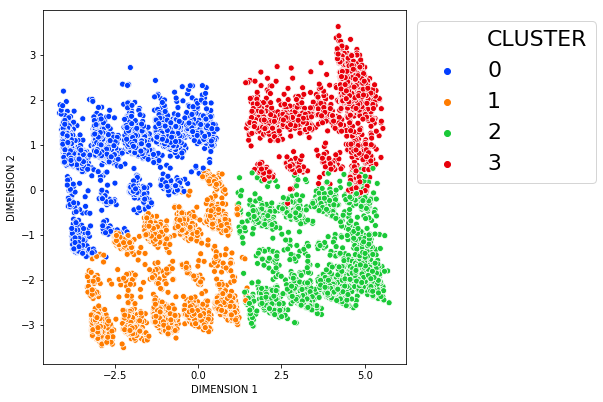

In [25]:
fig, ax = plt.subplots(figsize=(6.5, 6.5))

#legend = ['GROUP A','GROUP B', 'GROUP C', 'GROUP D']
palette = sns.color_palette("bright", 4)  #Choosing color
_ = plt.rcParams.update({'font.size': 22})
_ = sns.scatterplot(x='DIMENSION X', y='DIMENSION Y', data=df_sf, hue='CLUSTER', palette=palette)
_ = plt.xlabel('DIMENSION 1')
_ = plt.ylabel('DIMENSION 2')
_ = ax.legend(bbox_to_anchor=(1.0, 1.0))
# ax.text(-5, 2.5, 'GROUP 2')
# ax.text(3, -2.5, 'GROUP 1')
# ax.text(-4, -2.5, 'GROUP 0')
# ax.text(3, 5, 'GROUP 3')
plt.show()

In [26]:
#df_sf.to_csv('../data/processed/Kmeans_sanfrancisco.csv', index=False)

## 2. Miami

In [27]:
EST_MSA = 33100
name_location = 'Miami-Fort Lauderdale-Pompano Beach'

In [28]:
df_miami = df[df.EST_MSA == 33100]

In [29]:
df_miami = df_miami.loc[:, demographics+shopping_vars]

In [30]:
df_miami.head()

,EGENDER,RHISPANIC,RRACE,EEDUC,MS,THHLD_NUMKID,THHLD_NUMADLT,INCOME,EXPNS_DIF,ONLINE,PICK-UP,IN-STORE,RFID-NFC,CASH,AVOID RESTR,RESUME RESTR
136,1.0,1.0,1.0,7.0,5.0,0.0,2.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
647,2.0,1.0,2.0,6.0,1.0,0.0,5.0,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
648,1.0,2.0,1.0,7.0,1.0,2.0,6.0,8.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
651,2.0,1.0,1.0,3.0,1.0,2.0,2.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
652,1.0,1.0,2.0,5.0,5.0,0.0,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
df_miami = df_miami.replace({np.nan: 0})

In [32]:
df_miami.rename({'CHNGHOW1': 'ONLINE',
           'CHNGHOW2': 'PICK-UP',
           'CHNGHOW3': 'IN-STORE',
           'CHNGHOW4': 'RFID-NFC', 
           'CHNGHOW5': 'CASH', 
           'CHNGHOW6': 'AVOID RESTR',
           'CHNGHOW7': 'RESUME RESTR'}, axis=1, inplace=True)

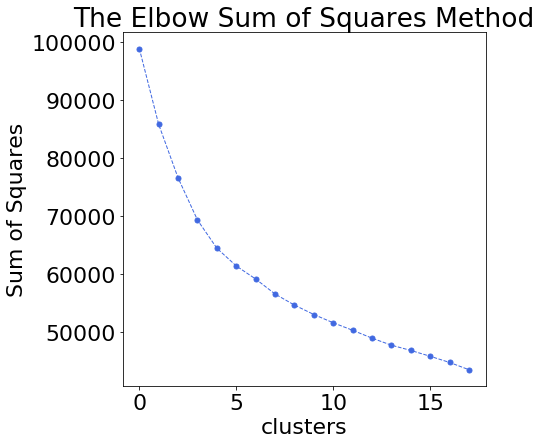

In [33]:
x_cols = df_miami
K = np.arange(2, 20, 1)
inertias = []

for k in K:
    model_miami = KMeans(n_clusters=k)
    model_miami.fit(x_cols)
    inertias.append(model_miami.inertia_)
    
f, ax = plt.subplots(figsize=(6.5, 6.5))  
_ = plt.plot(inertias, linewidth=1, markersize=5, marker='o', linestyle='dashed', color='royalblue') 
_ = plt.xlabel('clusters')
_ = plt.ylabel('Sum of Squares')
_ = plt.title('The Elbow Sum of Squares Method')
plt.show()

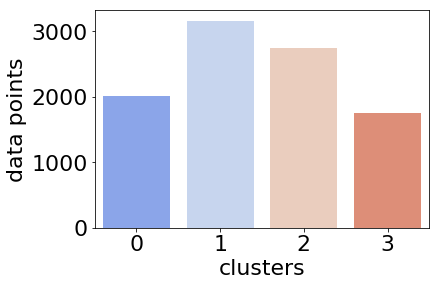

In [34]:
k = 4
model = KMeans(n_clusters=k, random_state=0)
labels_true = model.fit_predict(x_cols)
df_miami['CLUSTER'] = labels_true

df_clusters = df_miami.groupby('CLUSTER').count().head()
_ = sns.countplot(x=df_miami['CLUSTER'], data=df_miami, palette='coolwarm')
_ = plt.xlabel('clusters')
_ = plt.ylabel('data points')

In [35]:
df_miami['CLUSTER'].value_counts(normalize=True)

1    0.326784
2    0.283661
0    0.207653
3    0.181903
Name: CLUSTER, dtype: float64

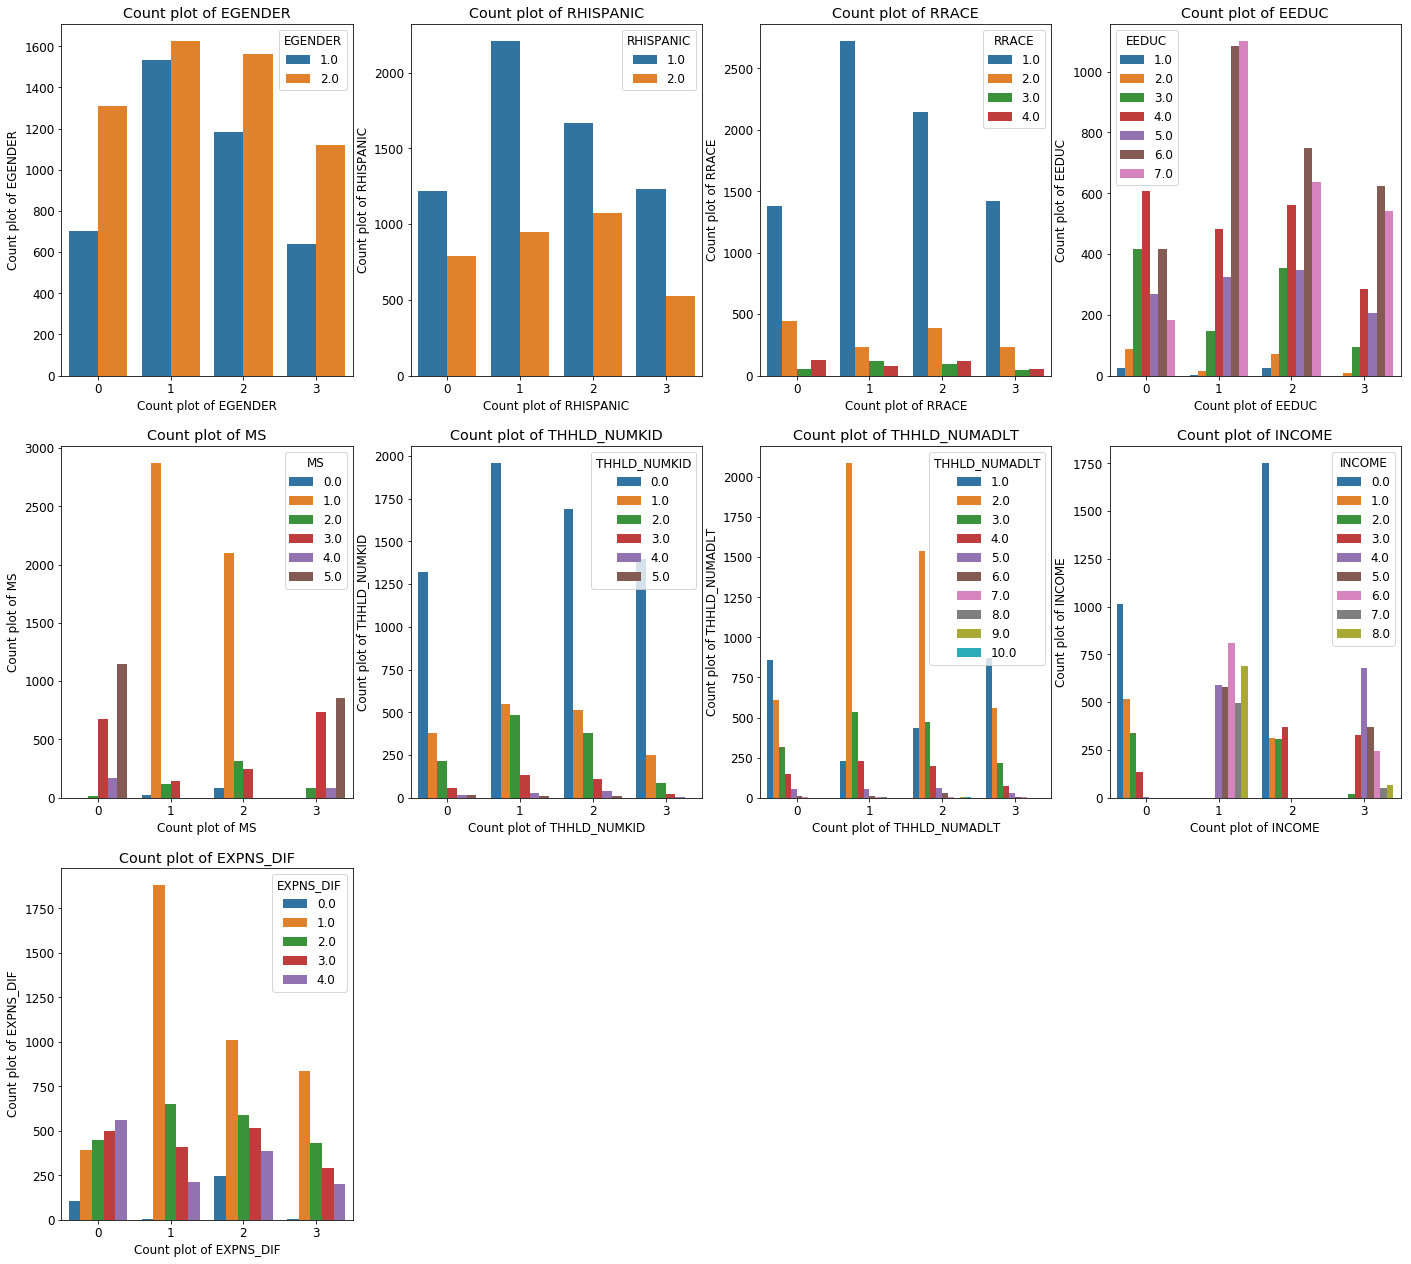

In [36]:
plt.figure(figsize=(24,22))
vars_to_look = demographics
for i, var in enumerate(vars_to_look):
    _ = plt.rcParams.update({'font.size': 12})
    plt.subplot(3,4,i+1)
    sns.countplot(x='CLUSTER', hue=var, data=df_miami)
    plt.title("Count plot of " + var) 
    plt.xlabel("Count plot of " + var)   
    plt.ylabel("Count plot of " + var)   
    #plt.legend(fontsize='xx-small')

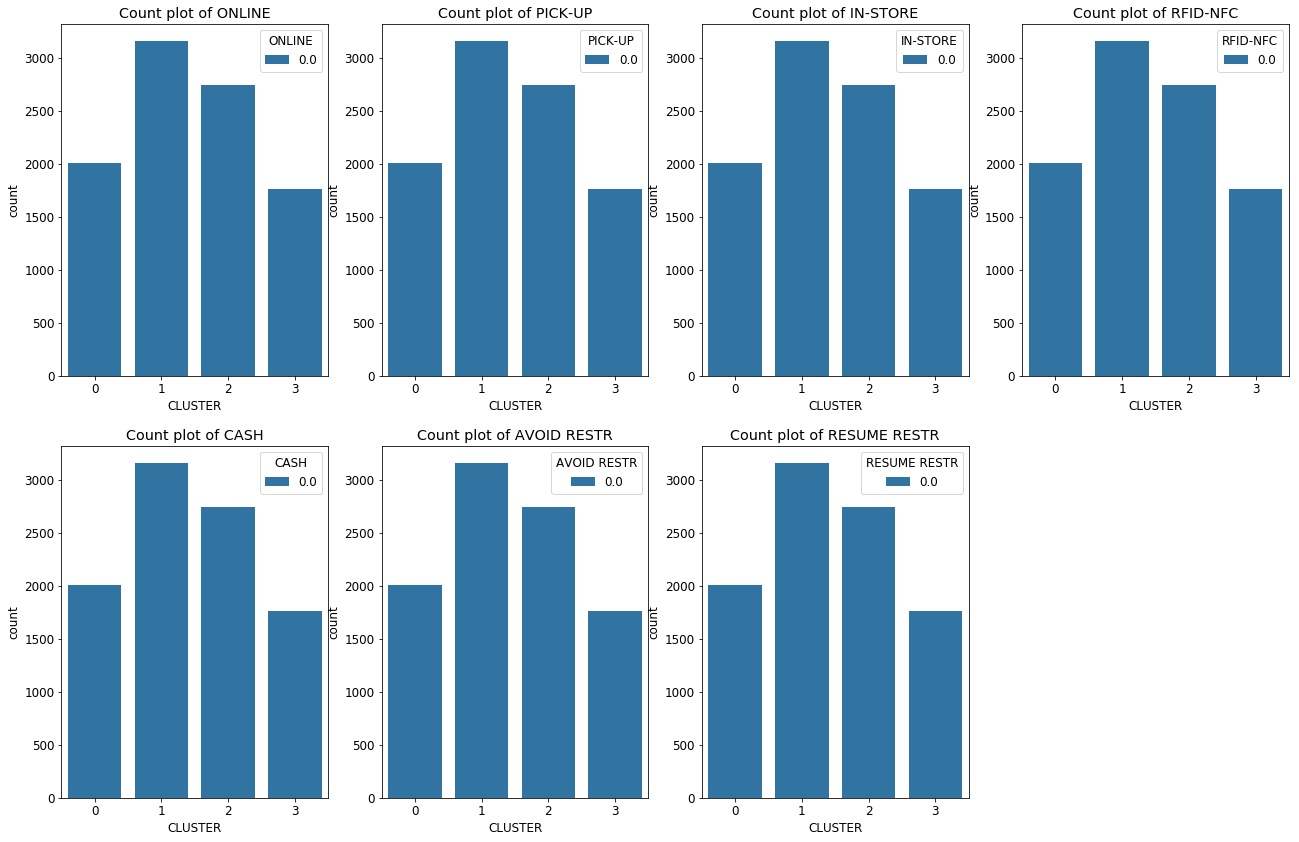

In [37]:
plt.figure(figsize=(22,22))
vars_to_look = shopping_vars
for i, var in enumerate(vars_to_look):
    plt.subplot(3,4,i+1)
    if i ==10:
        plt.xticks(rotation = 90)
    sns.countplot(hue=var, x='CLUSTER', data=df_miami)
    plt.title("Count plot of " + var)    

In [38]:
temp_income = df_miami.groupby(['CLUSTER', 'AVOID RESTR']).count()
temp_income = (temp_income/temp_income.groupby(level=[0]).sum())*100
temp_income

,,EGENDER,RHISPANIC,RRACE,EEDUC,MS,THHLD_NUMKID,THHLD_NUMADLT,INCOME,EXPNS_DIF,ONLINE,PICK-UP,IN-STORE,RFID-NFC,CASH,RESUME RESTR
CLUSTER,AVOID RESTR,,,,,,,,,,,,,,,
0,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
2,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
3,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


In [39]:
temp_income = df_miami.groupby(['CLUSTER', 'RESUME RESTR']).count()
temp_income = (temp_income/temp_income.groupby(level=[0]).sum())*100
temp_income

,,EGENDER,RHISPANIC,RRACE,EEDUC,MS,THHLD_NUMKID,THHLD_NUMADLT,INCOME,EXPNS_DIF,ONLINE,PICK-UP,IN-STORE,RFID-NFC,CASH,AVOID RESTR
CLUSTER,RESUME RESTR,,,,,,,,,,,,,,,
0,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
2,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
3,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


In [40]:
temp_income = df_miami.groupby(['CLUSTER', 'ONLINE']).count()
temp_income = (temp_income/temp_income.groupby(level=[0]).sum())*100
temp_income

,,EGENDER,RHISPANIC,RRACE,EEDUC,MS,THHLD_NUMKID,THHLD_NUMADLT,INCOME,EXPNS_DIF,PICK-UP,IN-STORE,RFID-NFC,CASH,AVOID RESTR,RESUME RESTR
CLUSTER,ONLINE,,,,,,,,,,,,,,,
0,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
2,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
3,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


In [41]:
temp_income = df_miami.groupby(['CLUSTER', 'PICK-UP']).count()
temp_income = (temp_income/temp_income.groupby(level=[0]).sum())*100
temp_income

,,EGENDER,RHISPANIC,RRACE,EEDUC,MS,THHLD_NUMKID,THHLD_NUMADLT,INCOME,EXPNS_DIF,ONLINE,IN-STORE,RFID-NFC,CASH,AVOID RESTR,RESUME RESTR
CLUSTER,PICK-UP,,,,,,,,,,,,,,,
0,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
2,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
3,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


In [42]:
temp_income = df_miami.groupby(['CLUSTER', 'IN-STORE']).count()
temp_income = (temp_income/temp_income.groupby(level=[0]).sum())*100
temp_income

,,EGENDER,RHISPANIC,RRACE,EEDUC,MS,THHLD_NUMKID,THHLD_NUMADLT,INCOME,EXPNS_DIF,ONLINE,PICK-UP,RFID-NFC,CASH,AVOID RESTR,RESUME RESTR
CLUSTER,IN-STORE,,,,,,,,,,,,,,,
0,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
2,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
3,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


In [43]:
temp_income = df_miami.groupby(['CLUSTER', 'RFID-NFC']).count()
temp_income = (temp_income/temp_income.groupby(level=[0]).sum())*100
temp_income

,,EGENDER,RHISPANIC,RRACE,EEDUC,MS,THHLD_NUMKID,THHLD_NUMADLT,INCOME,EXPNS_DIF,ONLINE,PICK-UP,IN-STORE,CASH,AVOID RESTR,RESUME RESTR
CLUSTER,RFID-NFC,,,,,,,,,,,,,,,
0,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
2,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
3,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


In [44]:
temp_income = df_miami.groupby(['CLUSTER', 'CASH']).count()
temp_income = (temp_income/temp_income.groupby(level=[0]).sum())*100
temp_income

,,EGENDER,RHISPANIC,RRACE,EEDUC,MS,THHLD_NUMKID,THHLD_NUMADLT,INCOME,EXPNS_DIF,ONLINE,PICK-UP,IN-STORE,RFID-NFC,AVOID RESTR,RESUME RESTR
CLUSTER,CASH,,,,,,,,,,,,,,,
0,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
2,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
3,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


In [45]:
pca_miami = PCA(n_components=2)
points = pca_miami.fit_transform(x_cols)

print(pca_miami.explained_variance_ratio_)


df_miami['DIMENSION X'] = points[:, 0]
df_miami['DIMENSION Y'] = points[:, 1]

[ 0.45229111  0.14694551]


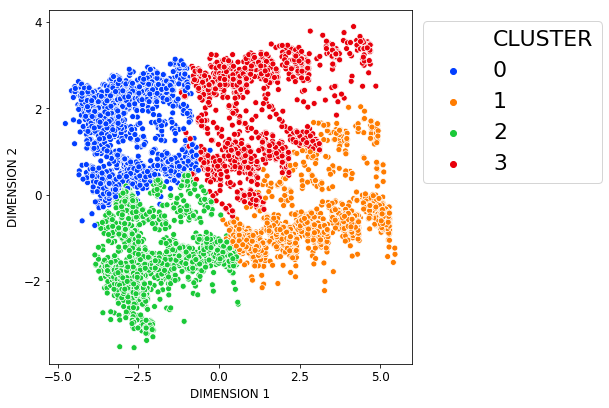

In [46]:
fig, ax = plt.subplots(figsize=(6.5, 6.5))

#legend = ['GROUP A','GROUP B', 'GROUP C', 'GROUP D']
palette = sns.color_palette("bright", 4)  #Choosing color
_ = plt.rcParams.update({'font.size': 22})
_ = sns.scatterplot(x='DIMENSION X', y='DIMENSION Y', data=df_miami, hue='CLUSTER', palette=palette)
_ = plt.xlabel('DIMENSION 1')
_ = plt.ylabel('DIMENSION 2')
_ = ax.legend(bbox_to_anchor=(1.0, 1.0))
# ax.text(-5, 2.5, 'GROUP 2')
# ax.text(3, -2.5, 'GROUP 1')
# ax.text(-4, -2.5, 'GROUP 0')
# ax.text(3, 5, 'GROUP 3')
plt.show()

In [47]:
#df_miami.to_csv('../data/processed/Kmeans_miami.csv', index=False)